# Импортирање на потребните библиотеки

In [ ]:
!pip install stellargraph

In [ ]:
from stellargraph.datasets import Cora
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Вчитување податоци

In [ ]:
# го вчитуваме податочното множество Cora кое е составено од научни
# публикации класифицирани во 7 класи
# секоја публикација е опишана со вектор од вредности (0/1) кои означуваат
# присуство/отсуство на зборови од предефиниран вокабулар на зборови
# публикациите претставуваат јазли во графот
# врска помеѓу 2 публикации постои доколку едната публикација ја цитира другата
dataset = Cora()
G, node_subjects = dataset.load()

In [ ]:
# приказ на информации за графот
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [ ]:
# го делиме множеството на подмножества за тренирање, валидација и тестирање
train_subjects, test_subjects = train_test_split(node_subjects, test_size=0.2, stratify=node_subjects)
val_subjects, test_subjects = train_test_split(test_subjects, test_size=0.5, stratify=test_subjects)

In [ ]:
# за класификација потребно е класите да ги претставиме како one-hot вектори
# за таа цел инстанцираме LabelBinarizer објект
label_binarizer = LabelBinarizer()

# ги трансформираме класите во one-hot вектори
train_targets = label_binarizer.fit_transform(train_subjects)
val_targets = label_binarizer.transform(val_subjects)
test_targets = label_binarizer.transform(test_subjects)

# Креирање модел

In [ ]:
# со цел пренесување на податоците од графот во Keras модел 
# потребно е да креира генератор
# бидејќи целта на моделот е класификација на јазли, а GCN е full-batch модел
# може да се користи FullBatchNodeGenerator со вредност gcn за 
# аргументот method
generator = FullBatchNodeGenerator(G, method='gcn')

Using GCN (local pooling) filters...


In [ ]:
# креирање итератори на јазли кои ќе се користат за тренирање,
# валидација и тестирање на моделот
train_gen = generator.flow(train_subjects.index, train_targets)
val_gen = generator.flow(val_subjects.index, val_targets)
test_gen = generator.flow(test_subjects.index, test_targets)

In [ ]:
# за класификација на јазли со моделот GCN потребно е да 
# се креира објект кој ќе го претставува моделот, со следните аргументи
# layer_sizes - листа на големини на скриените слоеви
# activations - листа на активациски функции на скриените слоеви
# generator - генератор на податоци
# dropout - процент за регуларизација (dropout) на секој слој
gcn = GCN(layer_sizes=[16, 16], activations=['relu', 'relu'], generator=generator, dropout=0.5)

# извлекување на влезните и излезните слоеви од моделот GCN
x_inp, x_out = gcn.in_out_tensors()

# излезен слој за класата
predictions = Dense(units=train_targets.shape[1], activation='softmax')(x_out)

# креирање објект кој ќе го претставува моделот со соодветните 
# влезни и излезни слоеви
model = Model(inputs=x_inp, outputs=predictions)

# пред да се тренира, потребно е моделот да се компајлира
# со поставување на аргументот loss дефинираме категориска крос-ентропија
# како функција на загуба
# со поставување на аргументот optimizer дефинираме Adam оптимизатор со рата
# на учење еднаква на 0.01
# со поставување на аргументот metrics дефинираме точност како метрика за 
# следење на перформансите на моделот при тренирање
model.compile(optimizer=Adam(learning_rate=0.01), loss=categorical_crossentropy, metrics=['accuracy'])

# Тренирање

In [ ]:
# при тренирање на моделот покрај влезните и излезните податоци, потребно е 
# да се постават вредности за аргументите epochs што претставува број на 
# епохи, validation_data што претставува податоци за валидација, shuffle што
# претставува информација за тоа дали да се прави промена на редоследот на 
# податоците во различни епохи и опционално verbose со што се дефинира
# интензитет на информации за процесот на тренирање
model.fit(train_gen, epochs=3, validation_data=val_gen, shuffle=False, verbose=2)

Epoch 1/3
1/1 - 1s - loss: 1.9503 - accuracy: 0.1168 - val_loss: 1.8914 - val_accuracy: 0.3026
Epoch 2/3
1/1 - 0s - loss: 1.8853 - accuracy: 0.3038 - val_loss: 1.8279 - val_accuracy: 0.3026
Epoch 3/3
1/1 - 0s - loss: 1.8165 - accuracy: 0.3029 - val_loss: 1.7612 - val_accuracy: 0.3026


# Евалуација

In [ ]:
# евалуација на моделот со што се добиваат вредности за
# функцијата на загуба и точноста
model.evaluate(test_gen)

1/1 [==============================] - 0s 53ms/step - loss: 1.7463 - accuracy: 0.3026


[1.7462713718414307, 0.3025830388069153]

# Мрежни вгнездувања

In [ ]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)

In [ ]:
embedding_model = Model(inputs=x_inp, outputs=x_out)
emb = embedding_model.predict(all_gen).squeeze(0)

In [ ]:
tsne = TSNE(n_components=2)
X_reduced = tsne.fit_transform(emb)

[Text(0, 0.5, '$X_2$'),
 Text(0.5, 0, '$X_1$'),
 Text(0.5, 1.0, 'TSNE visualization of GCN embeddings for cora dataset'),
 None]

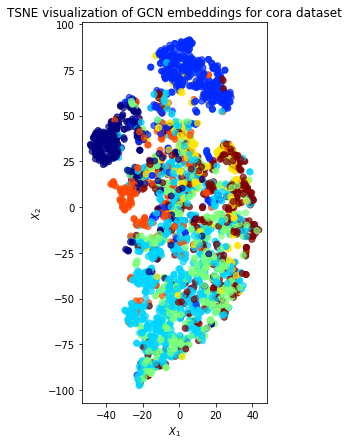

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype('category').cat.codes,
    cmap='jet',
    alpha=0.7,
)
ax.set(
    aspect='equal',
    xlabel='$X_1$',
    ylabel='$X_2$',
    title=f'TSNE visualization of GCN embeddings for cora dataset',
)